Hi! This is my work, where I mapped the 2020 congressional election votes to their districts. I then normalized it so we can see the value as -1 (100% republican) and 1 (100% democrat).
100% is not equivalent to 100% of votes for the district, just the max value in a list of votes tallied

Citations:
```
{cite}`IG0UN2_2017`
```

In [1]:
#import geopandas and normal pandas, for plotting and dataframes
import geopandas as gpd
import pandas as pd
#plot libraries for colormaps
import matplotlib.colors as mcol
import matplotlib.cm as cm

ModuleNotFoundError: No module named 'geopandas'

In [11]:
#loadd the congress district map. Found this on ArcGIS, which is a third party resource granted by the clerk of the house
ly = gpd.read_file("v10/cd117.gdb/")
congress = pd.read_csv("1976-2020-house.csv")
#select all rows from year 2020
congress = congress[congress['year'] == 2020]

In [12]:
#add a standard code to each dataframe ex: AL1
#Note: for the MIT data {congress} the "district" column may have a leading 0. My workaround was to convert to an integer and back to string

for i, item in congress.iterrows( ):
    val = item["state_po"] + str(int(item["district"]))
    congress.at[i, "code"] = val


for i, item in ly.iterrows():
    val = item["STATE_ABBR"] + str(int(item["CDFIPS"]))
    ly.at[i, "code"] = val


In [13]:
#group by district
grp = congress.groupby("code")

In [14]:
dm = "DEMOCRAT"
rp = "REPUBLICAN"

#here we go. Subtract party-A from party-B and you get an either negative or positive number
dists = [["district", "value"]]
for name, group in grp:
    dem = group[group["party"] == dm]
    rep = group[group["party"] == rp]
    votes = dem["candidatevotes"].sum() - rep["candidatevotes"].sum()
    dists.append([name, votes])

#we turn our list into a dataframe with the columns
dists = pd.DataFrame(dists[1:], columns=dists[0])

In [15]:

#grab the MAX value which is the max votes for party-A and Min value for Minimum value for party-B
mx = dists["value"].max()
mn = dists["value"].min()

#normalize it. The value will now be between -1 and 1
for i, row in dists.iterrows():
    if row["value"] > 0:
        dists.at[i, "value"] = (row["value"] / mx) 
    else:
        dists.at[i, "value"] = (row["value"] / mn) * -1






In [16]:
#add these -1 to 1 values to our geopandas dataframe and make sure there arent any codes. Make sure that only valid districts exist. If we have to drop a row, print it

for i, item in dists.iterrows():
    dist = item["district"]
    val = item["value"]
    if dist not in ly["code"].values:
        print(dist)
        dists.drop(i, inplace=True)
    ly.loc[ly["code"] == dist, "value"] = val 

DC0


<AxesSubplot:>

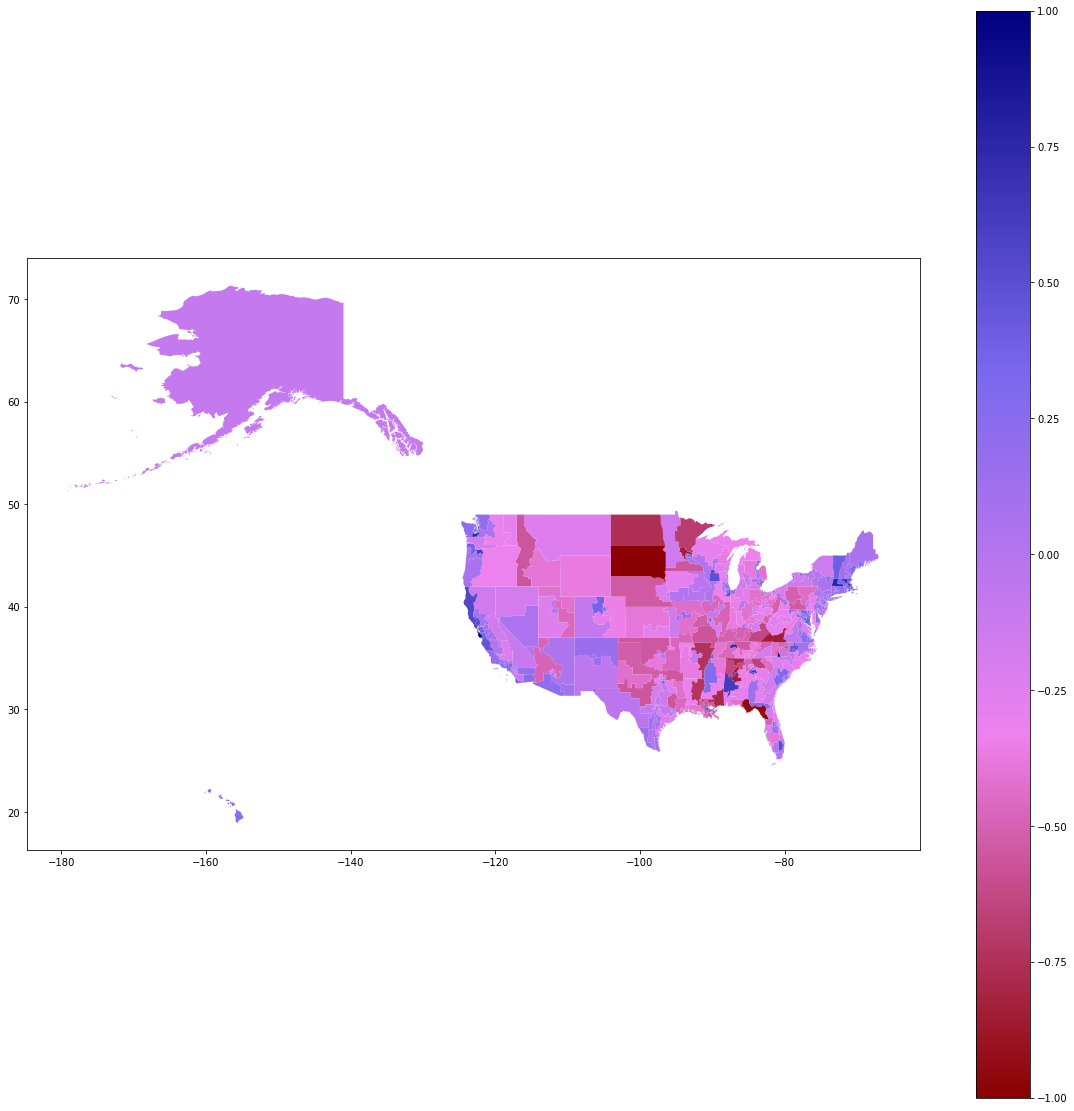

In [17]:
#make a colormap red to violet to purple to blue
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["darkred", "violet", "mediumslateblue", "navy"])

#plot the map
ly.plot(column="value", cmap=cm1, legend=True, figsize=(20, 20))